### Company Market Cap Prediction

Given data about big companies, let's try to predict the **market capitalization** of a given company.

We will use a variety of regression models to make our predictions.

Data source: https://www.kaggle.com/datasets/winston56/fortune-500-data-2021

### Getting Started

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('Fortune_1000.csv')
data

,company,rank,rank_change,revenue,profit,num. of employees,sector,city,state,newcomer,ceo_founder,ceo_woman,profitable,prev_rank,CEO,Website,Ticker,Market Cap
0,Walmart,1,0.0,572754.0,13673.0,2300000.0,Retailing,Bentonville,AR,no,no,no,yes,1.0,C. Douglas McMillon,https://www.stock.walmart.com,WMT,352037
1,Amazon,2,0.0,469822.0,33364.0,1608000.0,Retailing,Seattle,WA,no,no,no,yes,2.0,Andrew R. Jassy,www.amazon.com,AMZN,1202717
2,Apple,3,0.0,365817.0,94680.0,154000.0,Technology,Cupertino,CA,no,no,no,yes,3.0,Timothy D. Cook,www.apple.com,AAPL,2443962
3,CVS Health,4,0.0,292111.0,7910.0,258000.0,Health Care,Woonsocket,RI,no,no,yes,yes,4.0,Karen Lynch,https://www.cvshealth.com,CVS,125204
4,UnitedHealth Group,5,0.0,287597.0,17285.0,350000.0,Health Care,Minnetonka,MN,no,no,no,yes,5.0,Andrew P. Witty,www.unitedhealthgroup.com,UNH,500468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Vizio Holding,996,0.0,2124.0,-39.4,800.0,Industrials,Irvine,CA,no,yes,no,no,,William W. Wang,https://www.vizio.com,VZIO,1705.1
996,1-800-Flowers.com,997,0.0,2122.2,118.7,4800.0,Retailing,Jericho,NY,no,no,no,yes,,Christopher G. McCann,https://www.1800flowers.com,FLWS,830
997,Cowen,998,0.0,2112.8,295.6,1534.0,Financials,New York,NY,no,no,no,yes,,Jeffrey Solomon,https://www.cowen.com,COWN,1078
998,Ashland,999,0.0,2111.0,220.0,4100.0,Chemicals,Wilmington,DE,no,no,no,yes,,Guillermo Novo,https://www.ashland.com,ASH,5601.9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company            1000 non-null   object 
 1   rank               1000 non-null   int64  
 2   rank_change        1000 non-null   float64
 3   revenue            1000 non-null   float64
 4   profit             997 non-null    float64
 5   num. of employees  999 non-null    float64
 6   sector             1000 non-null   object 
 7   city               1000 non-null   object 
 8   state              1000 non-null   object 
 9   newcomer           1000 non-null   object 
 10  ceo_founder        1000 non-null   object 
 11  ceo_woman          1000 non-null   object 
 12  profitable         1000 non-null   object 
 13  prev_rank          1000 non-null   object 
 14  CEO                1000 non-null   object 
 15  Website            1000 non-null   object 
 16  Ticker             951 no

### Preprocessing

In [10]:
def preprocess_inputs(df):
    df = df.copy()
    # Drop unused columns
    df = df.drop(['rank', 'rank_change', 'company', 'prev_rank', 'CEO', 'Website', 'Ticker'], axis=1)

    # Encode missing values
    df['Market Cap'] = df['Market Cap'].replace('-', np.nan).astype(float)
    
    # Drop missing target rows
    missing_target_rows = df[df['Market Cap'].isna()].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)

    # Fill remainig missing values
    df['profit'] = df['profit'].fillna(df['profit'].mean())

    # Binary encoding 
    for column in ['ceo_founder', 'ceo_woman', 'profitable', 'newcomer']:
        df[column] = df[column].replace({'no': 0, 'yes': 1})

    # One-hot encoding 
    for column in ['sector', 'city', 'state']:
        dummies = pd.get_dummies(df[column], prefix=column, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)

    # Split the df into X, y
    y = df['Market Cap']
    X = df.drop('Market Cap', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [12]:
X_train.describe()

,revenue,profit,num. of employees,newcomer,ceo_founder,ceo_woman,profitable,sector_Aerospace & Defense,sector_Apparel,sector_Business Services,...,state_PA,state_PR,state_RI,state_SC,state_TN,state_TX,state_UT,state_VA,state_WA,state_WI
count,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,...,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02
mean,4.229421e-17,9.251859e-18,-3.172066e-17,3.436405e-17,7.401487e-17,-4.229421e-17,-1.057355e-16,-1.453863e-17,3.172066e-17,5.022437e-17,...,3.172066e-17,-2.643388e-18,2.643388e-17,2.114711e-17,2.643388e-18,1.850372e-17,3.172066e-17,1.586033e-17,4.493760e-17,3.172066e-17
std,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,...,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00,1.000745e+00
min,-3.761760e-01,-1.737510e+00,-3.084916e-01,-1.751424e-01,-2.379155e-01,-3.015113e-01,-2.559407e+00,-1.165103e-01,-1.404523e-01,-2.344036e-01,...,-2.272514e-01,-3.860457e-02,-5.463584e-02,-5.463584e-02,-1.659004e-01,-3.327819e-01,-7.738232e-02,-1.796053e-01,-1.229054e-01,-1.348400e-01
25%,-3.415956e-01,-3.378401e-01,-2.548576e-01,-1.751424e-01,-2.379155e-01,-3.015113e-01,3.907156e-01,-1.165103e-01,-1.404523e-01,-2.344036e-01,...,-2.272514e-01,-3.860457e-02,-5.463584e-02,-5.463584e-02,-1.659004e-01,-3.327819e-01,-7.738232e-02,-1.796053e-01,-1.229054e-01,-1.348400e-01
50%,-2.738149e-01,-2.567011e-01,-1.945257e-01,-1.751424e-01,-2.379155e-01,-3.015113e-01,3.907156e-01,-1.165103e-01,-1.404523e-01,-2.344036e-01,...,-2.272514e-01,-3.860457e-02,-5.463584e-02,-5.463584e-02,-1.659004e-01,-3.327819e-01,-7.738232e-02,-1.796053e-01,-1.229054e-01,-1.348400e-01
75%,-8.357931e-02,-5.976677e-02,-7.252456e-02,-1.751424e-01,-2.379155e-01,-3.015113e-01,3.907156e-01,-1.165103e-01,-1.404523e-01,-2.344036e-01,...,-2.272514e-01,-3.860457e-02,-5.463584e-02,-5.463584e-02,-1.659004e-01,-3.327819e-01,-7.738232e-02,-1.796053e-01,-1.229054e-01,-1.348400e-01
max,1.338791e+01,1.548170e+01,1.876744e+01,5.709641e+00,4.203173e+00,3.316625e+00,3.907156e-01,8.582929e+00,7.119853e+00,4.266146e+00,...,4.400413e+00,2.590367e+01,1.830301e+01,1.830301e+01,6.027714e+00,3.004971e+00,1.292285e+01,5.567764e+00,8.136338e+00,7.416198e+00


In [13]:
y_train

733     3871.1
719     1269.8
341    35145.5
291    62968.1
46     73458.0
        ...   
767      643.9
72     73403.0
908     3346.7
235    60728.3
37     41545.0
Name: Market Cap, Length: 672, dtype: float64

### Training

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Linear Regression (L2)": Ridge(),
    "Linear Regression (L1)": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Neural Network": MLPRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + ' trained.')

Linear Regression trained.
Linear Regression (L2) trained.
Linear Regression (L1) trained.
Decision Tree trained.
Neural Network trained.
Random Forest trained.
Gradient Boosting trained.


### Results

In [16]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(name + "RMSE : {:.2f}".format(rmse))

Linear RegressionRMSE : 6576872137965318144.00
Linear Regression (L2)RMSE : 117070.34
Linear Regression (L1)RMSE : 123320.82
Decision TreeRMSE : 129429.17
Neural NetworkRMSE : 197830.58
Random ForestRMSE : 116310.82
Gradient BoostingRMSE : 120359.15


In [17]:
for name, model in models.items():
    r2 = model.score(X_test, y_test)
    print(name + " R^2 Score: {:.5f}".format(r2))

Linear Regression R^2 Score: -1174185013456760779481022464.00000
Linear Regression (L2) R^2 Score: 0.62796
Linear Regression (L1) R^2 Score: 0.58717
Decision Tree R^2 Score: 0.54526
Neural Network R^2 Score: -0.06239
Random Forest R^2 Score: 0.63277
Gradient Boosting R^2 Score: 0.60676


In [19]:
y_test

241     17565.7
852     16949.3
436       637.5
386      8046.9
345    135987.6
         ...   
134     85967.0
459      4670.6
320     96022.7
57      33951.0
884      1594.5
Name: Market Cap, Length: 289, dtype: float64

<Axes: ylabel='Frequency'>

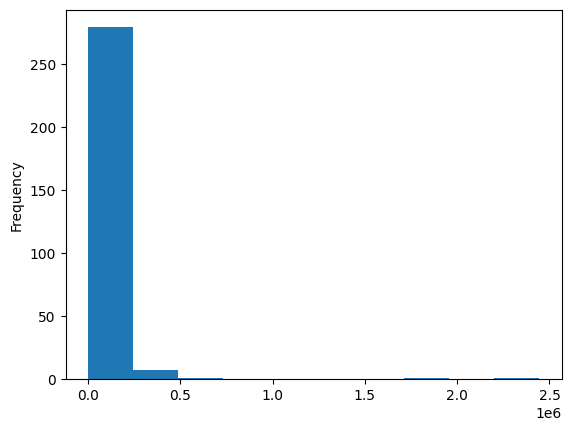

In [24]:
y_test.plot(kind='hist')